In [1]:
# 要件定義
# 6地域の縦横の大きさを統一して表示する．
# Norht America, Central America, South America
# West Europe, Eastern Europe, Northern Africa
# Southern Africa, Middle East, South Asia,
# Southeast Asia, East Asia, Oceania
# 都市マスクを黒か白で表示
# Heのurban land coverデータをドットで表示
# GPWを表示
# 大きな河川だけ表示する?流量が大きい(HydroShedsを参照)
# プロダクトはまずミニマルから作ろう

# 絶対に表示したい地域
# Southern Africa, South Asia, Middle East, 悪い例
# West Europe, South America, North America よい例
# 緯度経度に関しては国連の区分を参照するかkummu 2016を参照する
# kummu 2016
# The regions are based on UN macro regions aggregating the countries to larger units74
# with the difference that some of the largest regions were divided into smaller regions by Kummu et al.7
# to be more suitable for (historical) water analyses.
# 74. United Nations. United Nations World Macro Regions and Components. In: UN Map Library. United Nation (UN): http://www.un.org/depts/dhl/maplib/worldregions.htm, accessed December 2009 (2000).
# 7. Kummu, M., Ward, P. J., de Moel, H. & Varis, O. Is physical water scarcity a new phenomenon? Global assessment of water shortageover the last two millennia. Environmental Research Letters 5, 034006 (2010).

# Southern Africa: -17.8, 51.5, -35.0, 27.2
# Middle East:     25.6, 64.1, 12.4,  44.5
# South Asia:      60.2, 97.6, 6.2, 37.3

# West Europe: -11, 27.2, 35.7, 71.7
# South America: -83.4, -33, -56.7, 13.1
# North America: -130.3, -57.3, 49.4, 23.6

In [2]:
!pip install ipdb
import ipdb


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


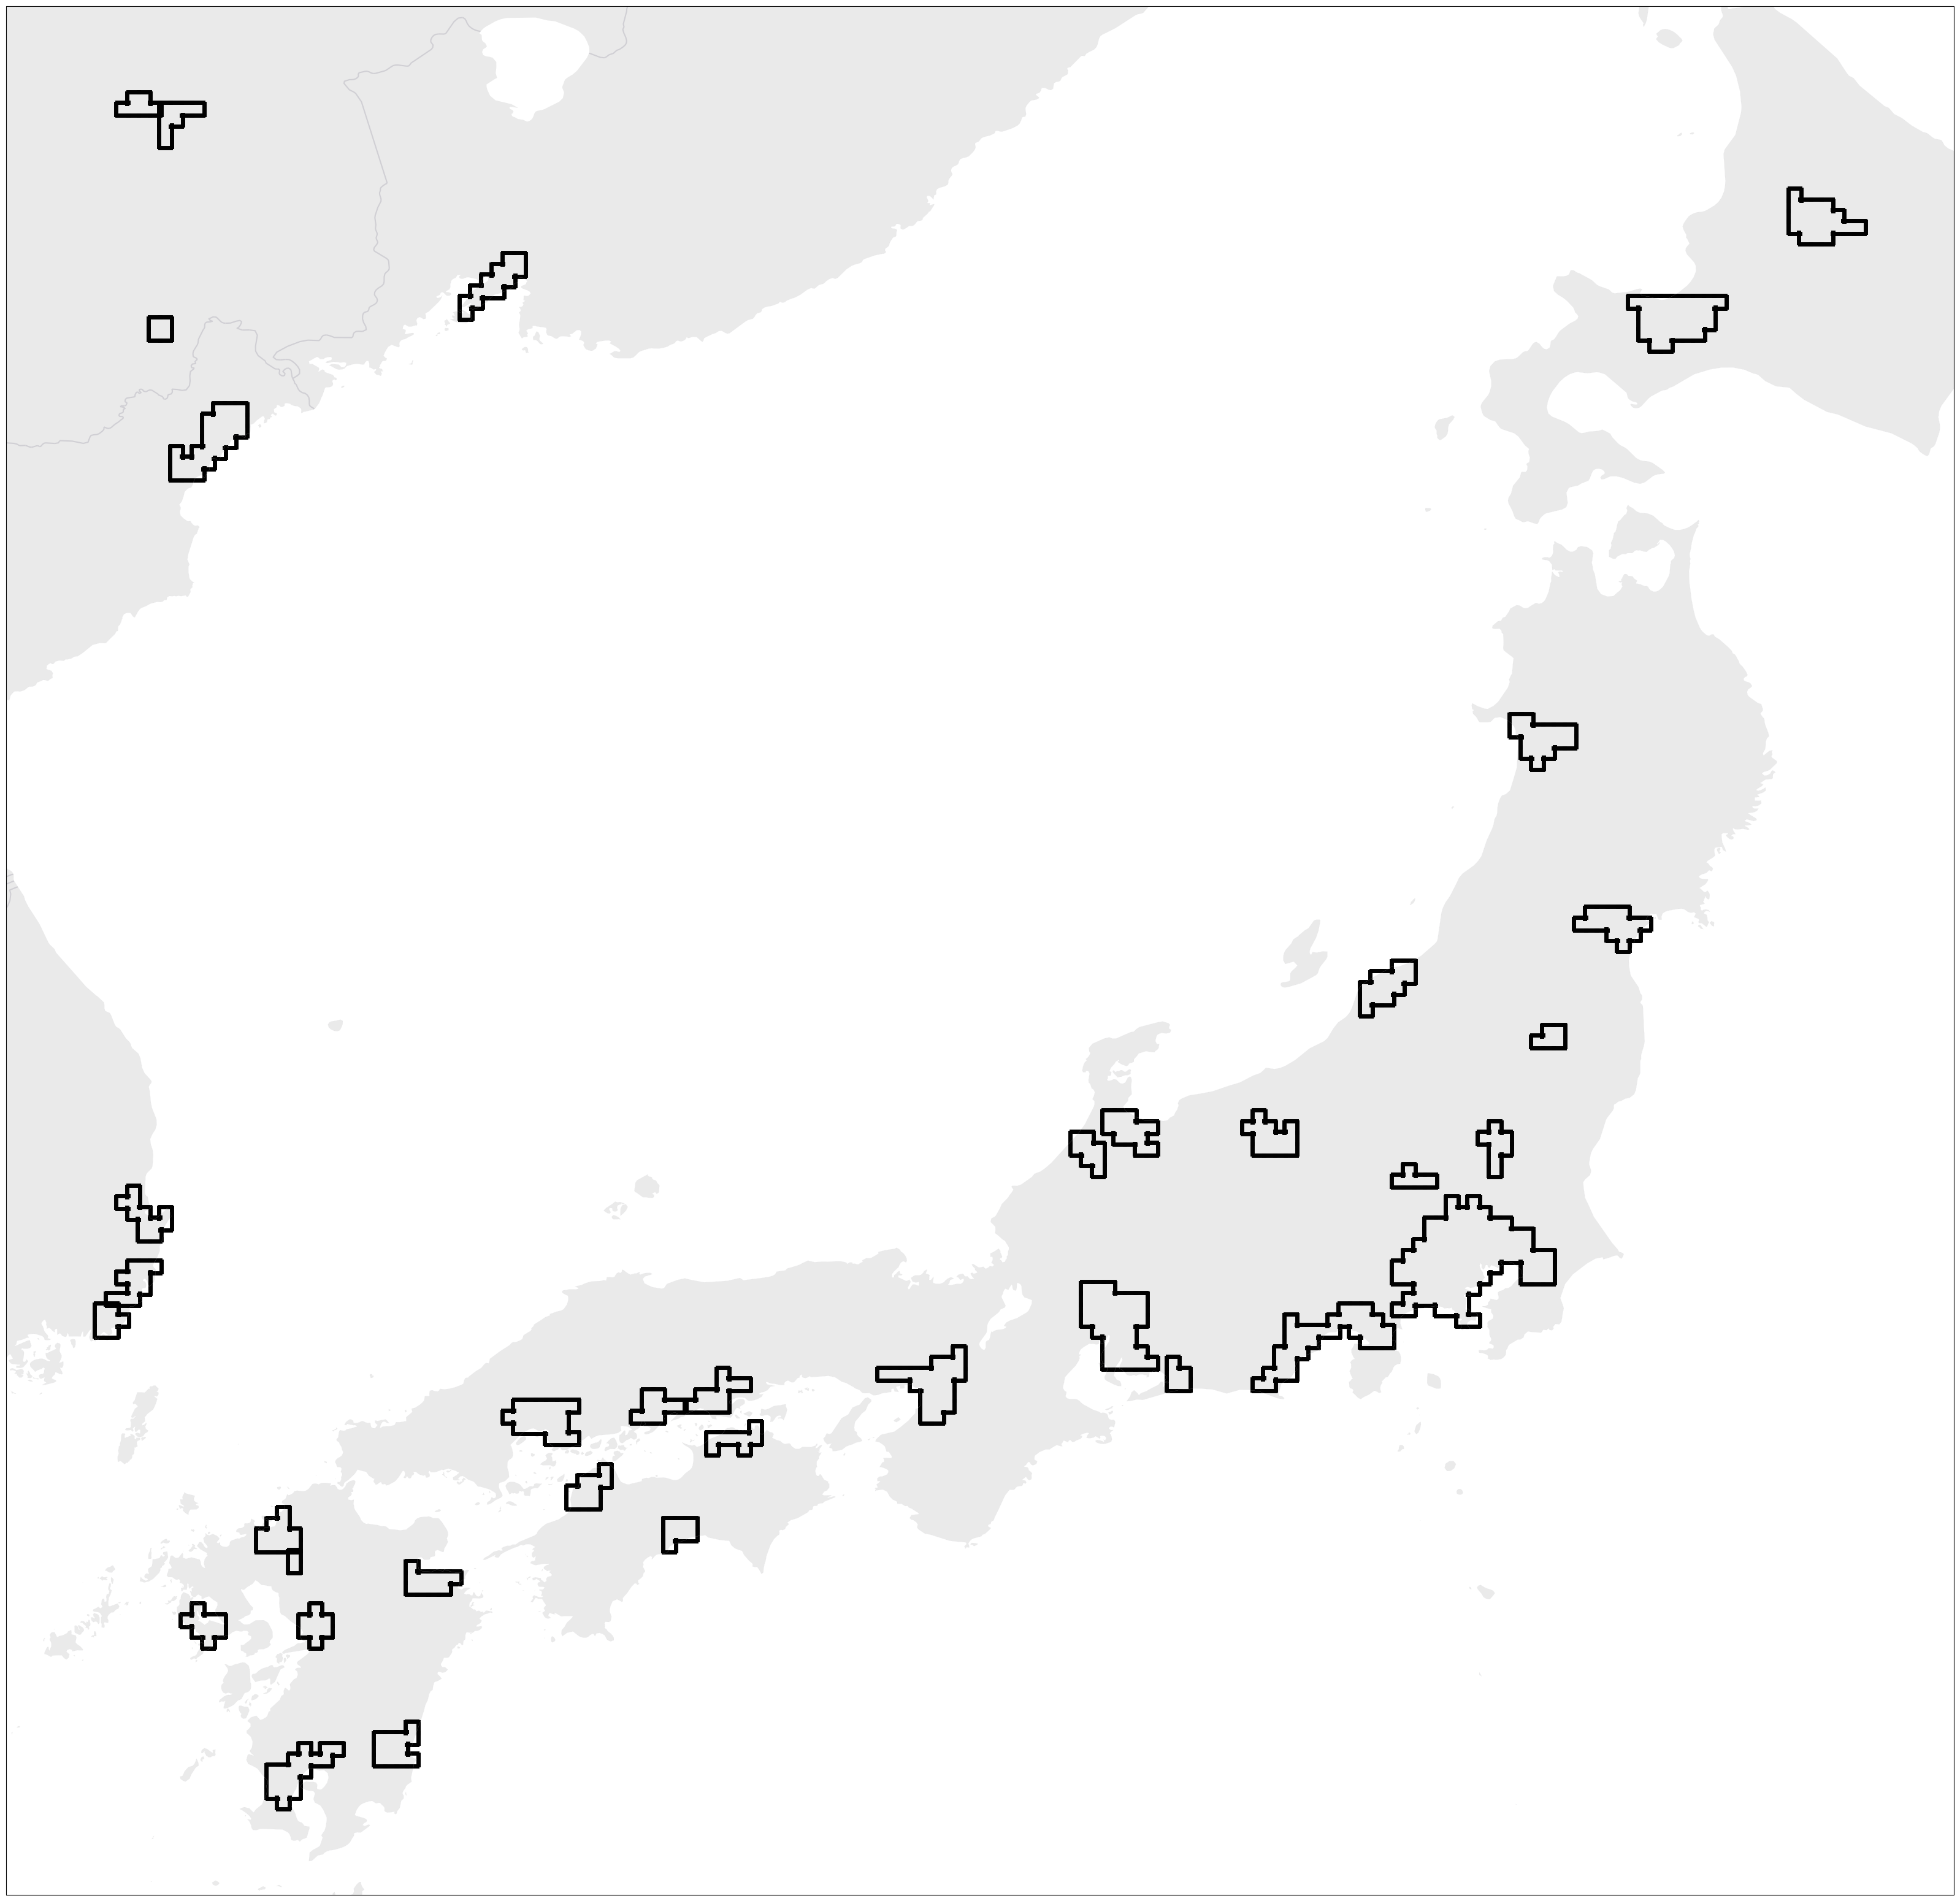

In [5]:
# import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def tokyo_plot(left, right, bottom, top, linewidth=5, padding=0.1):
    # gpw4
    # populatin text
    # he 2019
    # river path 
    # river discharge
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    citymask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
    city_mask = np.fromfile(citymask_path, dtype='float32').reshape(2160, 4320)
    citymask_cropped = city_mask[upperindex:lowerindex, leftindex:rightindex]
    uorder = np.unique(citymask_cropped)
    order = [int(c_tmp) for c_tmp in uorder if c_tmp != 0]
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    for city_num in order:
        city_masked = np.ma.masked_where(citymask_cropped != city_num, citymask_cropped)
        draw_mask_sotowaku_outer(img_extent, city_masked, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding)
        
    plt.show()

left, right, bottom, top = 129, 143, 30, 45
tokyo_plot(left, right, bottom, top)

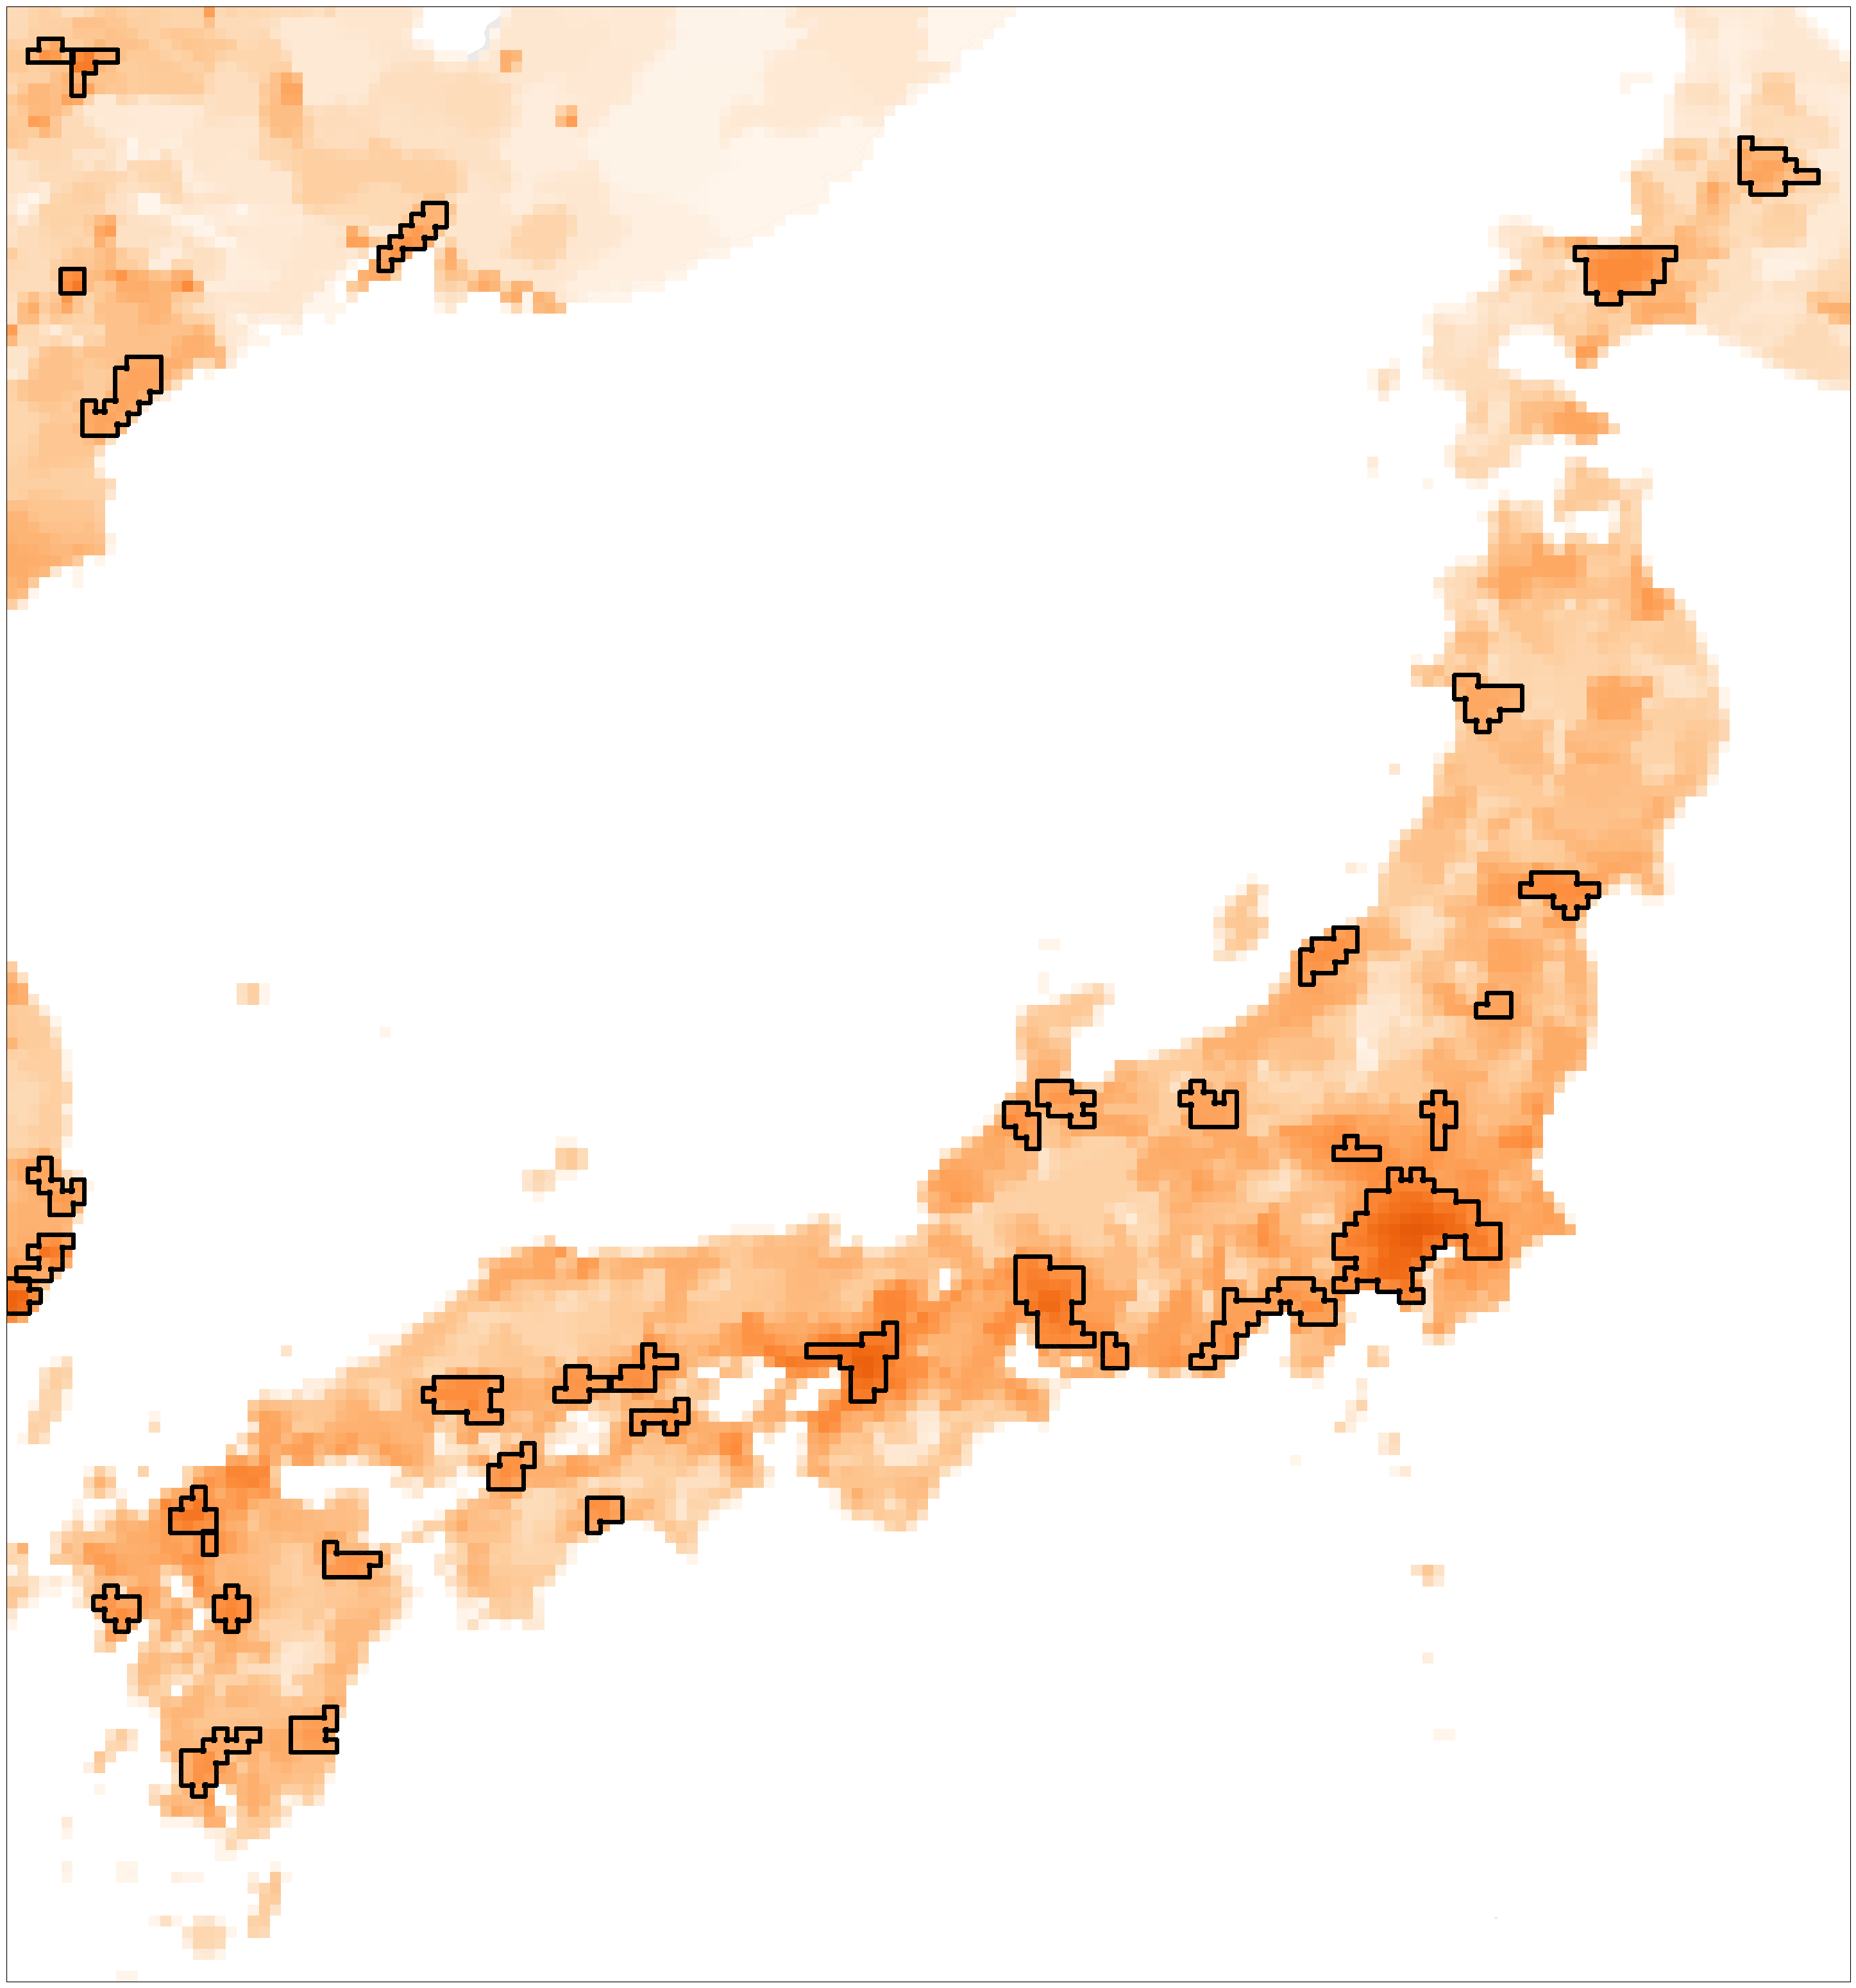

In [20]:
import matplotlib 

def tokyo_plot(left, right, bottom, top, linewidth=5, padding=0.1):
    # gpw4
    # populatin text
    # he 2019
    # river path 
    # river discharge

    # geography
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # mask
    citymask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
    city_mask = np.fromfile(citymask_path, dtype='float32').reshape(2160, 4320)
    citymask_cropped = city_mask[upperindex:lowerindex, leftindex:rightindex]

    # gpw4
    gpw_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
    gpw = np.fromfile(gpw_path, dtype='float32').reshape(2160, 4320)
    gpw_cropped = gpw[upperindex:lowerindex, leftindex:rightindex]
    gpw_masked = np.ma.masked_where(gpw_cropped == 0, gpw_cropped)

    # city num
    uorder = np.unique(citymask_cropped)
    order = [int(c_tmp) for c_tmp in uorder if c_tmp != 0]

    # ccrs
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(50,40))
    ax = plt.subplot(projection=projection)
    ax.set_extent(img_extent, projection)

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    pop = ax.imshow(gpw_masked, origin='upper', extent = img_extent, transform=projection, 
                    cmap='Oranges', 
                    norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=1e8)
                   )

    for city_num in order:
        city_masked = np.ma.masked_where(citymask_cropped != city_num, citymask_cropped)
        draw_mask_sotowaku_outer(img_extent, city_masked, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding)
        
    plt.show()

left, right, bottom, top = 129, 143, 30, 45
tokyo_plot(left, right, bottom, top)

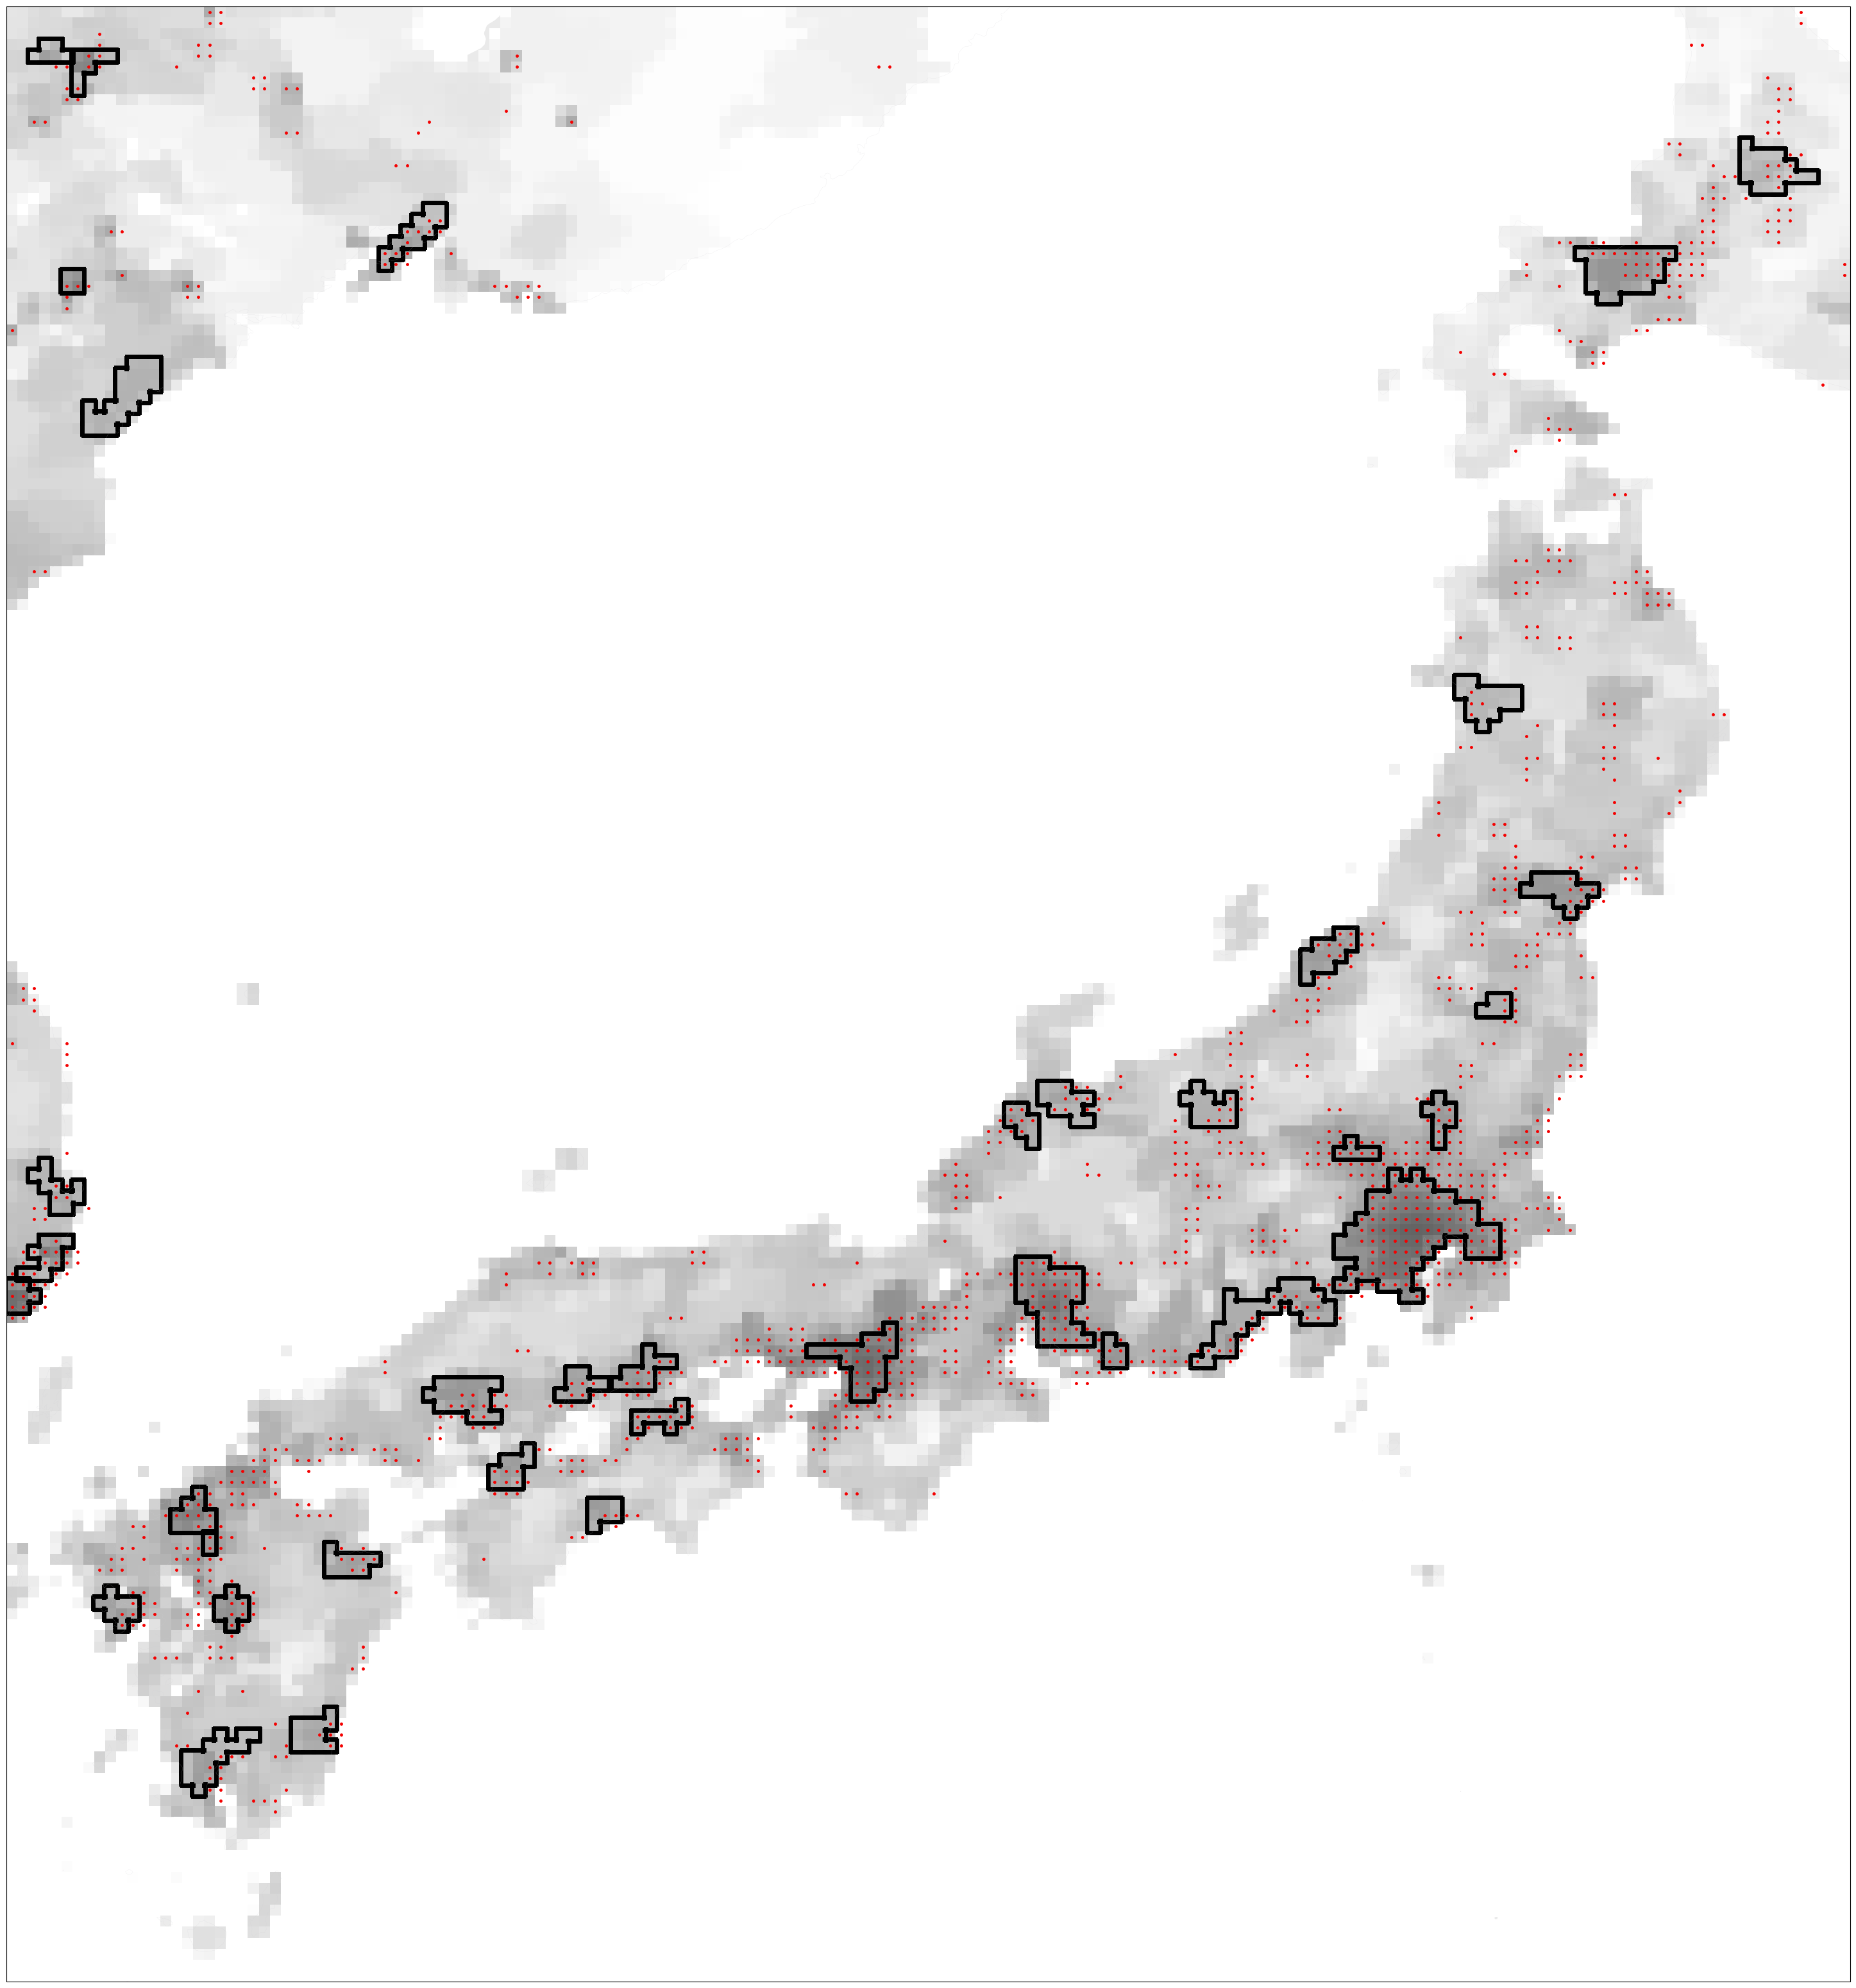

In [42]:
import matplotlib 

def landcover_tmp(extent, land_cropped, ax=None, markersize=5):
    # extent
    projection = ccrs.PlateCarree()
    
    # delta
    delta = 360/4320
    x_left = extent[0] + delta/2
    y_top = extent[3] - delta/2
    
    # cross
    for (i, j) in zip(*np.where(land_cropped == 1)):
        x_index = x_left + delta*j
        y_index = y_top - delta*i
        ax.plot(x_index, y_index, '.', color='#f40000', 
                markersize=markersize, transform=projection)

    return ax

def tokyo_plot(left, right, bottom, top, linewidth=5, padding=0.1):
    # he 2019
    # populatin text
    # river path 
    # river discharge

    # geography
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # mask
    citymask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
    city_mask = np.fromfile(citymask_path, dtype='float32').reshape(2160, 4320)
    citymask_cropped = city_mask[upperindex:lowerindex, leftindex:rightindex]

    # gpw4
    gpw_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
    gpw = np.fromfile(gpw_path, dtype='float32').reshape(2160, 4320)
    gpw_cropped = gpw[upperindex:lowerindex, leftindex:rightindex]
    gpw_masked = np.ma.masked_where(gpw_cropped == 0, gpw_cropped)

    # wup
    wup_path = f'{h08dir}/camacity/dat/cty_lst_/create_text/camacity_third.txt'

    # he 2019
    he_path = f'{h08dir}/camacity/dat/he__data/Global_Urban_Land_2010_upscaled.gl5'
    he = np.fromfile(he_path, dtype='float32').reshape(2160, 4320)
    he_cropped = he[upperindex:lowerindex, leftindex:rightindex]
    he_masked = np.ma.masked_where(he_cropped == 0, he_cropped)

    # city num
    uorder = np.unique(citymask_cropped)
    order = [int(c_tmp) for c_tmp in uorder if c_tmp != 0]

    # ccrs
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(50,40))
    ax = plt.subplot(projection=projection)
    ax.set_extent(img_extent, projection)

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    pop = ax.imshow(gpw_masked, origin='upper', extent = img_extent, transform=projection, 
                    cmap='Greys', 
                    norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=1e8)
                   )

    ax = landcover_tmp(img_extent, he_cropped, ax=ax, markersize=5)

    for city_num in order:
        city_masked = np.ma.masked_where(citymask_cropped != city_num, citymask_cropped)
        draw_mask_sotowaku_outer(img_extent, city_masked, ax=ax, 
                                 sotowaku_color='black', 
                                 linewidth=linewidth, padding=padding)

    plt.show()

left, right, bottom, top = 129, 143, 30, 45
tokyo_plot(left, right, bottom, top)

In [71]:
import os
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def landcover(extent, land_cropped, ax=None, markersize=5):
    # extent
    projection = ccrs.PlateCarree()
    
    # delta
    delta = 360/4320
    x_left = extent[0] + delta/2
    y_top = extent[3] - delta/2
    
    # cross
    for (i, j) in zip(*np.where(land_cropped == 1)):
        x_index = x_left + delta*j
        y_index = y_top - delta*i
        ax.plot(x_index, y_index, '.', 
                color='#ff0000', 
                alpha=0.8,
                markersize=markersize, transform=projection)

    return ax

def region_plot(left, right, bottom, top, dotwidth=5, linewidth=5, vmax=1e8, padding=0.0):
    # geography
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # mask
    citymask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
    city_mask = np.fromfile(citymask_path, dtype='float32').reshape(2160, 4320)
    citymask_cropped = city_mask[upperindex:lowerindex, leftindex:rightindex]

    # gpw4
    gpw_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
    gpw = np.fromfile(gpw_path, dtype='float32').reshape(2160, 4320)
    gpw_cropped = gpw[upperindex:lowerindex, leftindex:rightindex]
    gpw_masked = np.ma.masked_where(gpw_cropped == 0, gpw_cropped)

    # he 2019
    he_path = f'{h08dir}/camacity/dat/he__data/Global_Urban_Land_2010_upscaled.gl5'
    he = np.fromfile(he_path, dtype='float32').reshape(2160, 4320)
    he_cropped = he[upperindex:lowerindex, leftindex:rightindex]
    he_masked = np.ma.masked_where(he_cropped == 0, he_cropped)

    # city num
    uorder = np.unique(citymask_cropped)
    order = [int(c_tmp) for c_tmp in uorder if c_tmp != 0]

    # ccrs
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(50,50))
    ax = plt.subplot(projection=projection)
    ax.set_extent(img_extent, projection)

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1,edgecolor='#d0cfd4', zorder=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    pop = ax.imshow(gpw_masked, origin='upper', extent = img_extent, transform=projection, 
                    cmap='Greys', 
                    norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=vmax)
                   )

    ax = landcover(img_extent, he_cropped, ax=ax, markersize=dotwidth)

    for city_num in order:
        city_masked = np.ma.masked_where(citymask_cropped != city_num, citymask_cropped)
        draw_mask_sotowaku_outer(img_extent, city_masked, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding)
        
    gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(round(left/10)*10, right, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(round(bottom/10)*10, top, 10))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 80, 'color': 'black'}
    gl.ylabel_style = {'size': 80, 'color': 'black'}
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(True)

    plt.show()

In [72]:
# Southern Africa: -17.8, 51.5, -35.0, 27.2
# Middle East:     25.6, 64.1, 12.4,  44.5
# South Asia:      60.2, 97.6, 6.2, 37.3

# West Europe: -11, 27.2, 35.7, 71.7
# South America: -83.4, -33, -56.7, 13.1
# North America: -130.3, -57.3, 23.6, 49.4

In [ ]:
#Part of southern Africa
left, right, bottom, top = 16, 37, -35, -22
region_plot(left, right, bottom, top, dotwidth=5, linewidth=3, vmax=1e9)

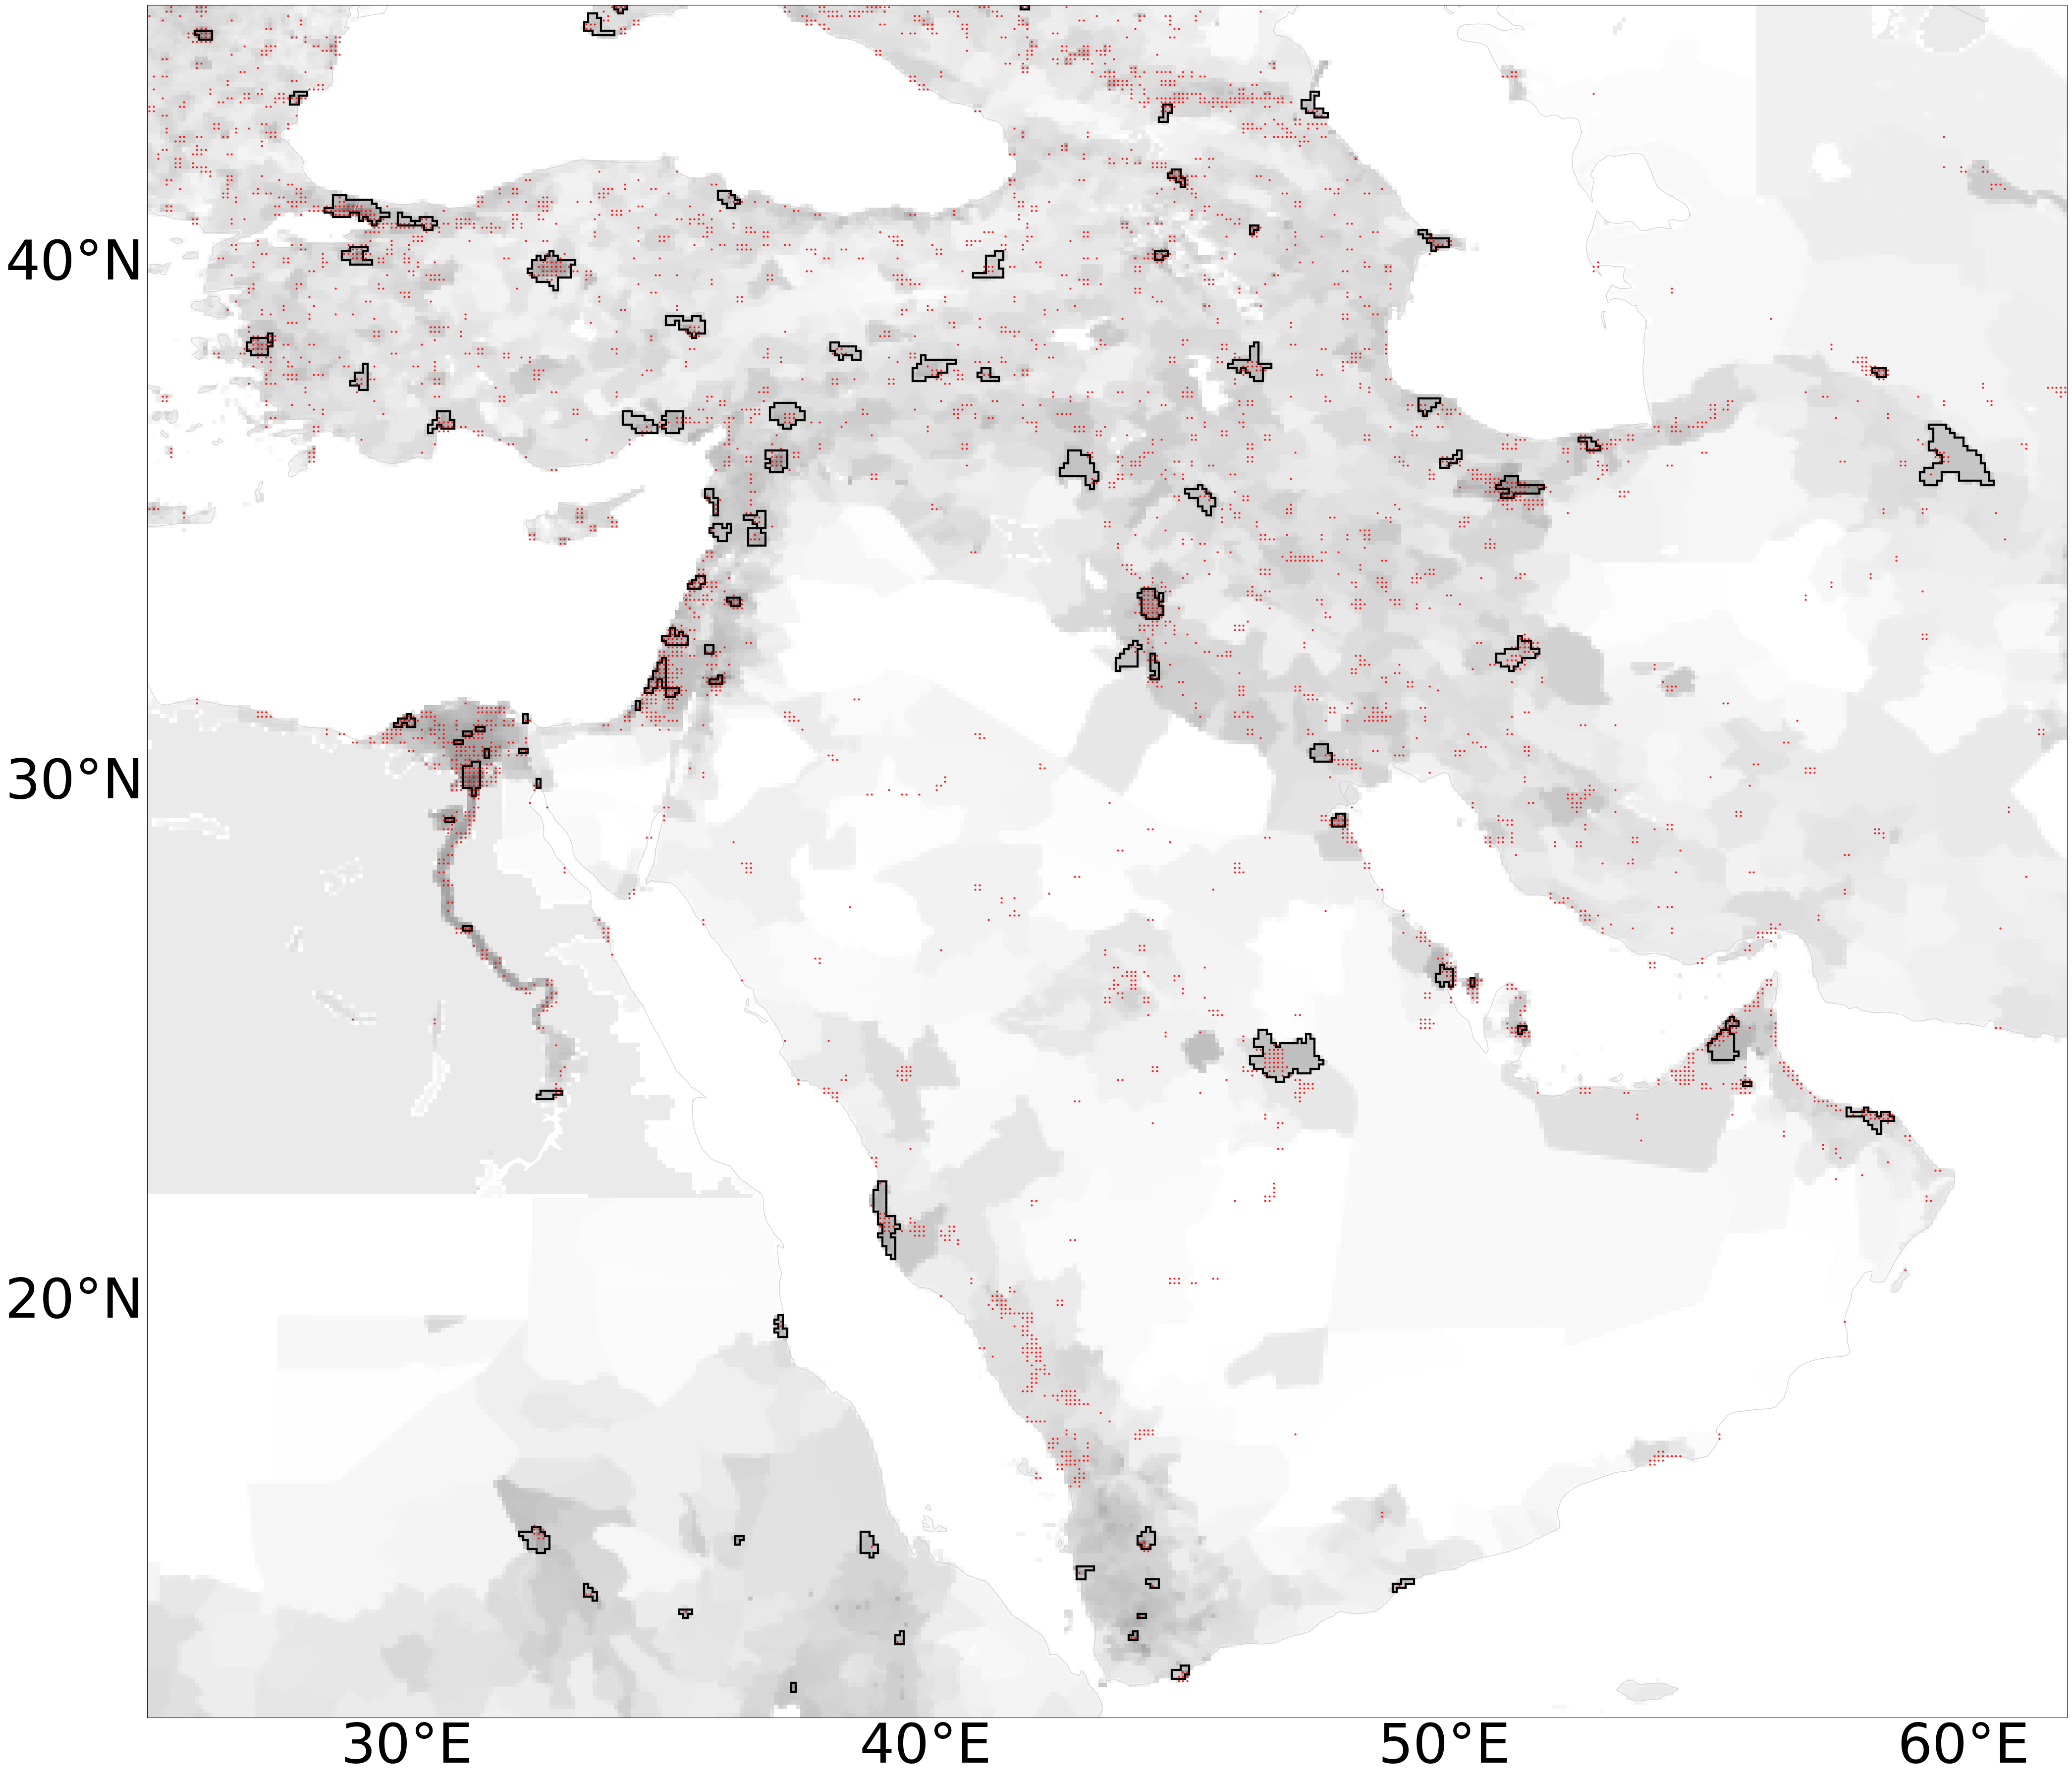

In [93]:
left, right, bottom, top = 25, 62, 12, 45
region_plot(left, right, bottom, top, dotwidth=4, linewidth=3, vmax=1e9)

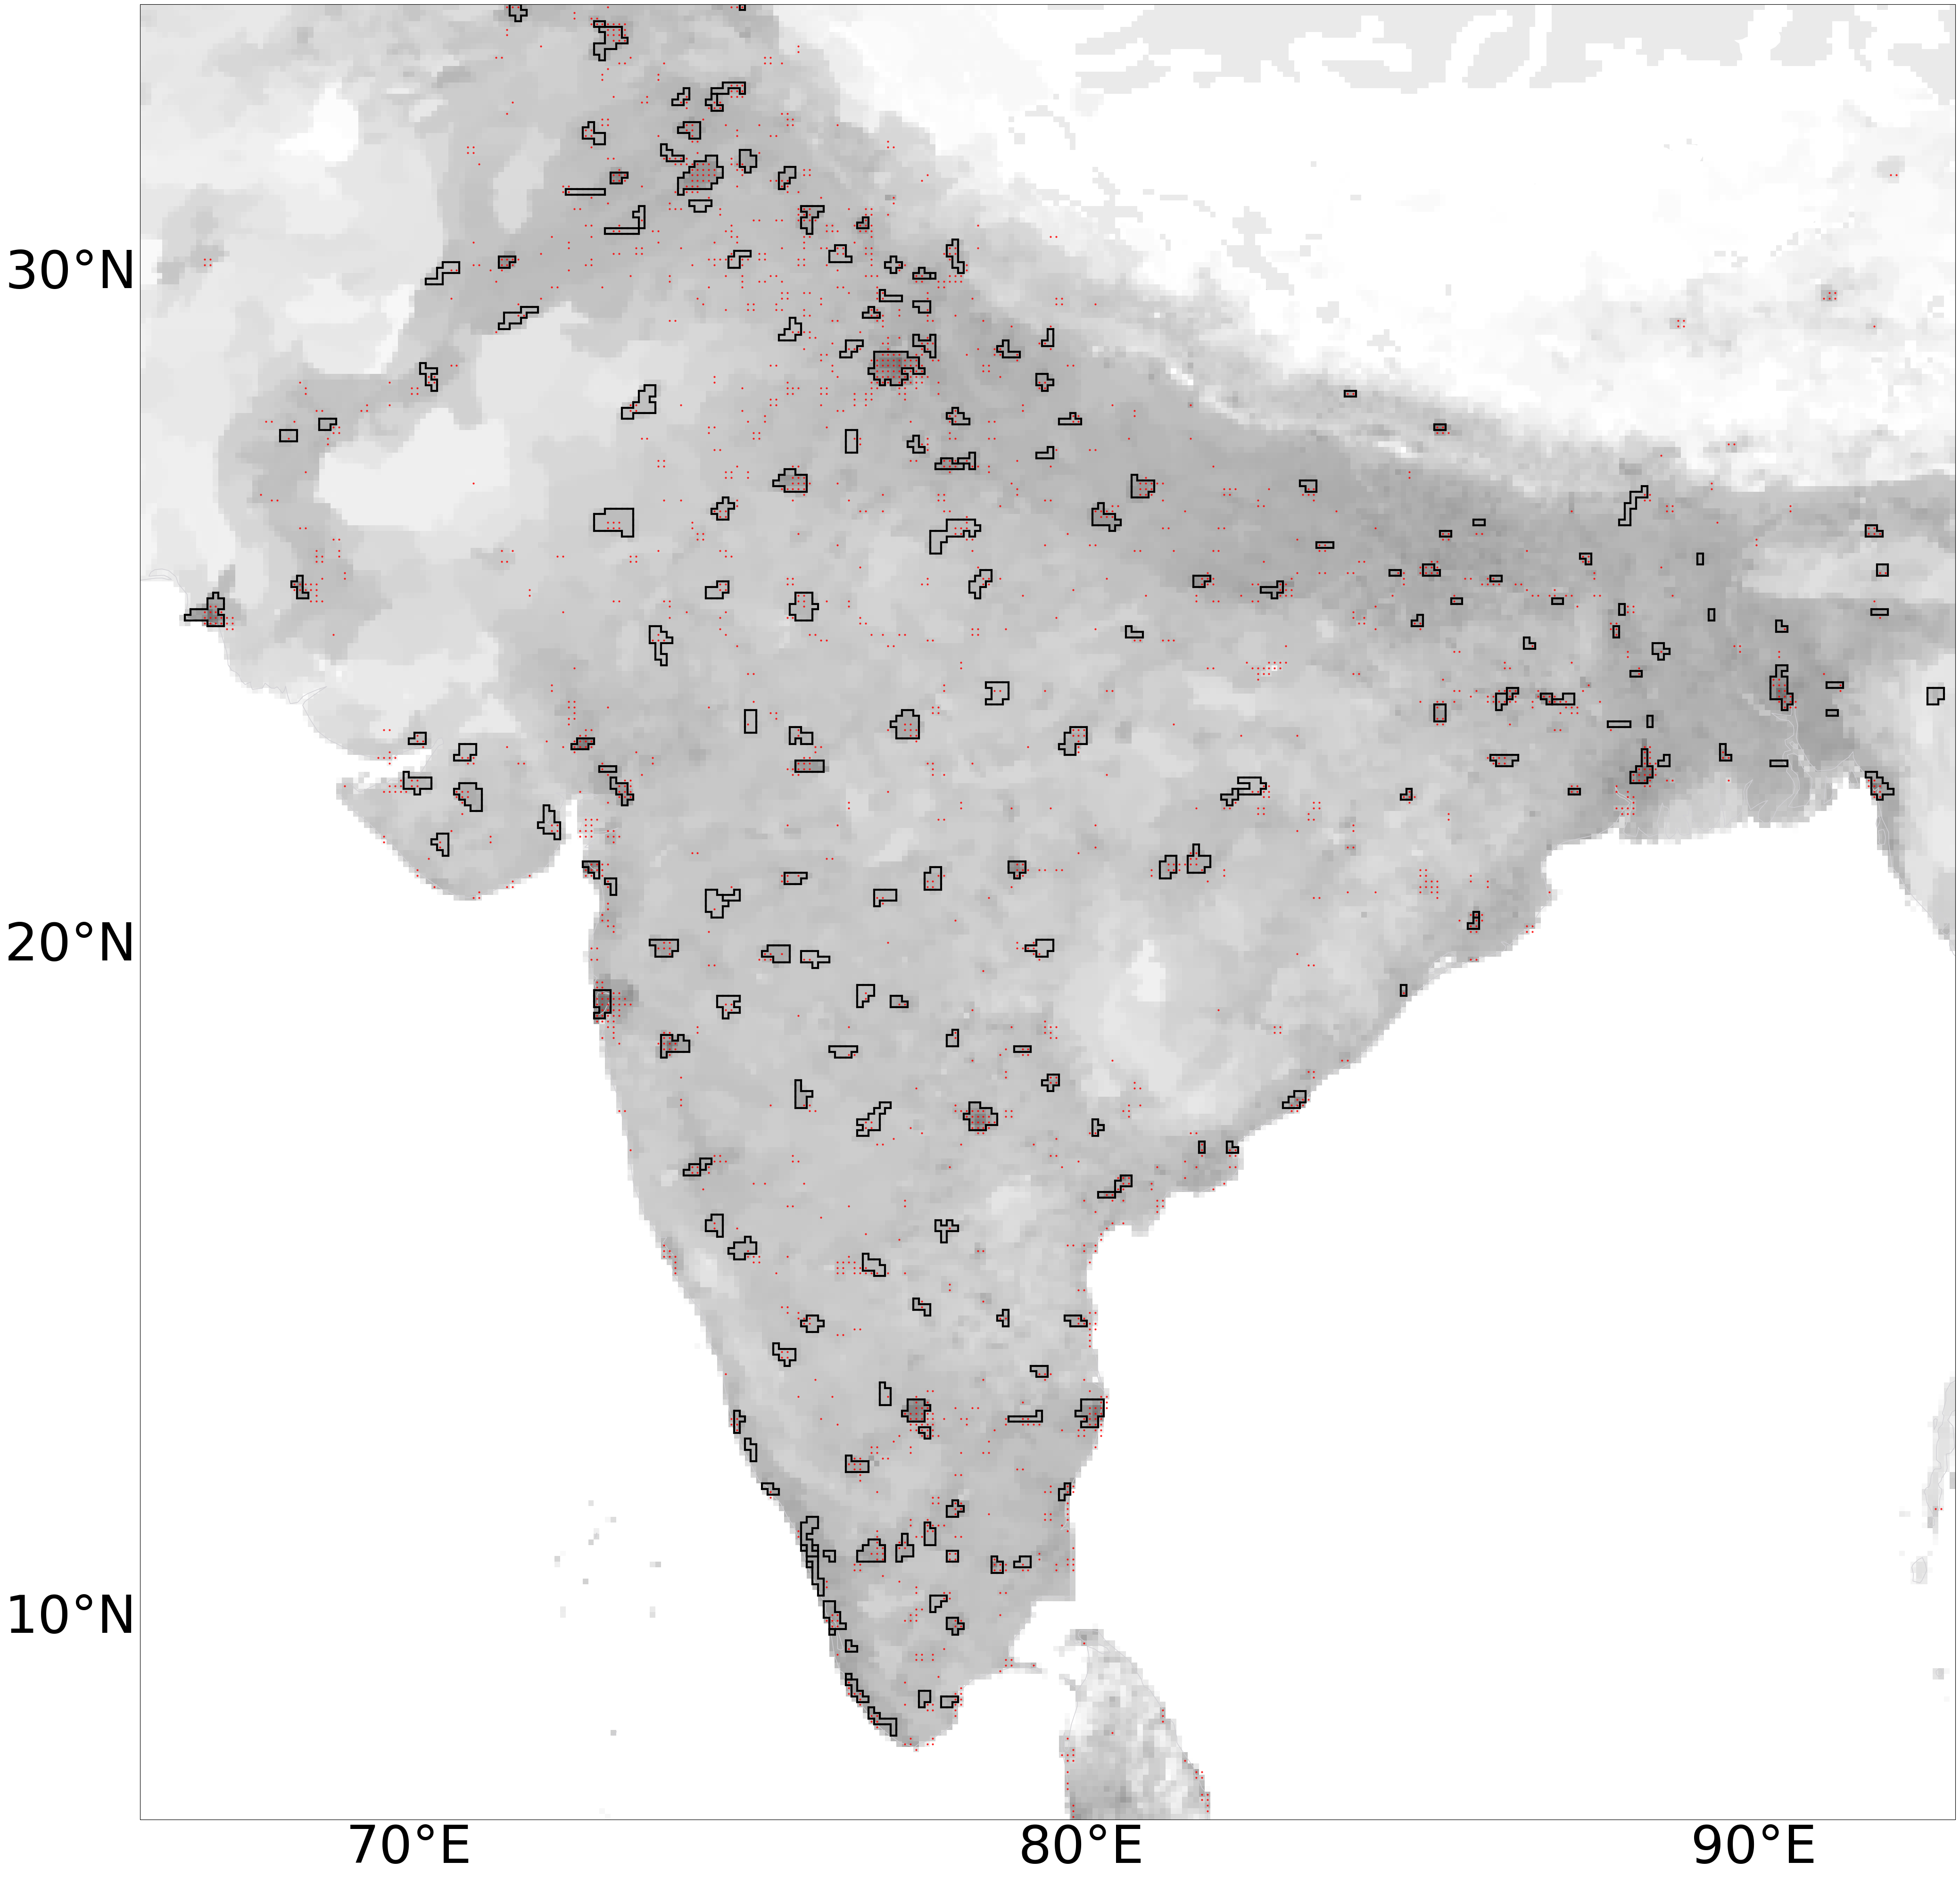

In [105]:
left, right, bottom, top = 66, 93, 7, 34
region_plot(left, right, bottom, top, dotwidth=4, linewidth=3, vmax=1e9)

In [ ]:
left, right, bottom, top = -9, 20, 37, 62
region_plot(left, right, bottom, top, dotwidth=4, linewidth=2, vmax=1e9)

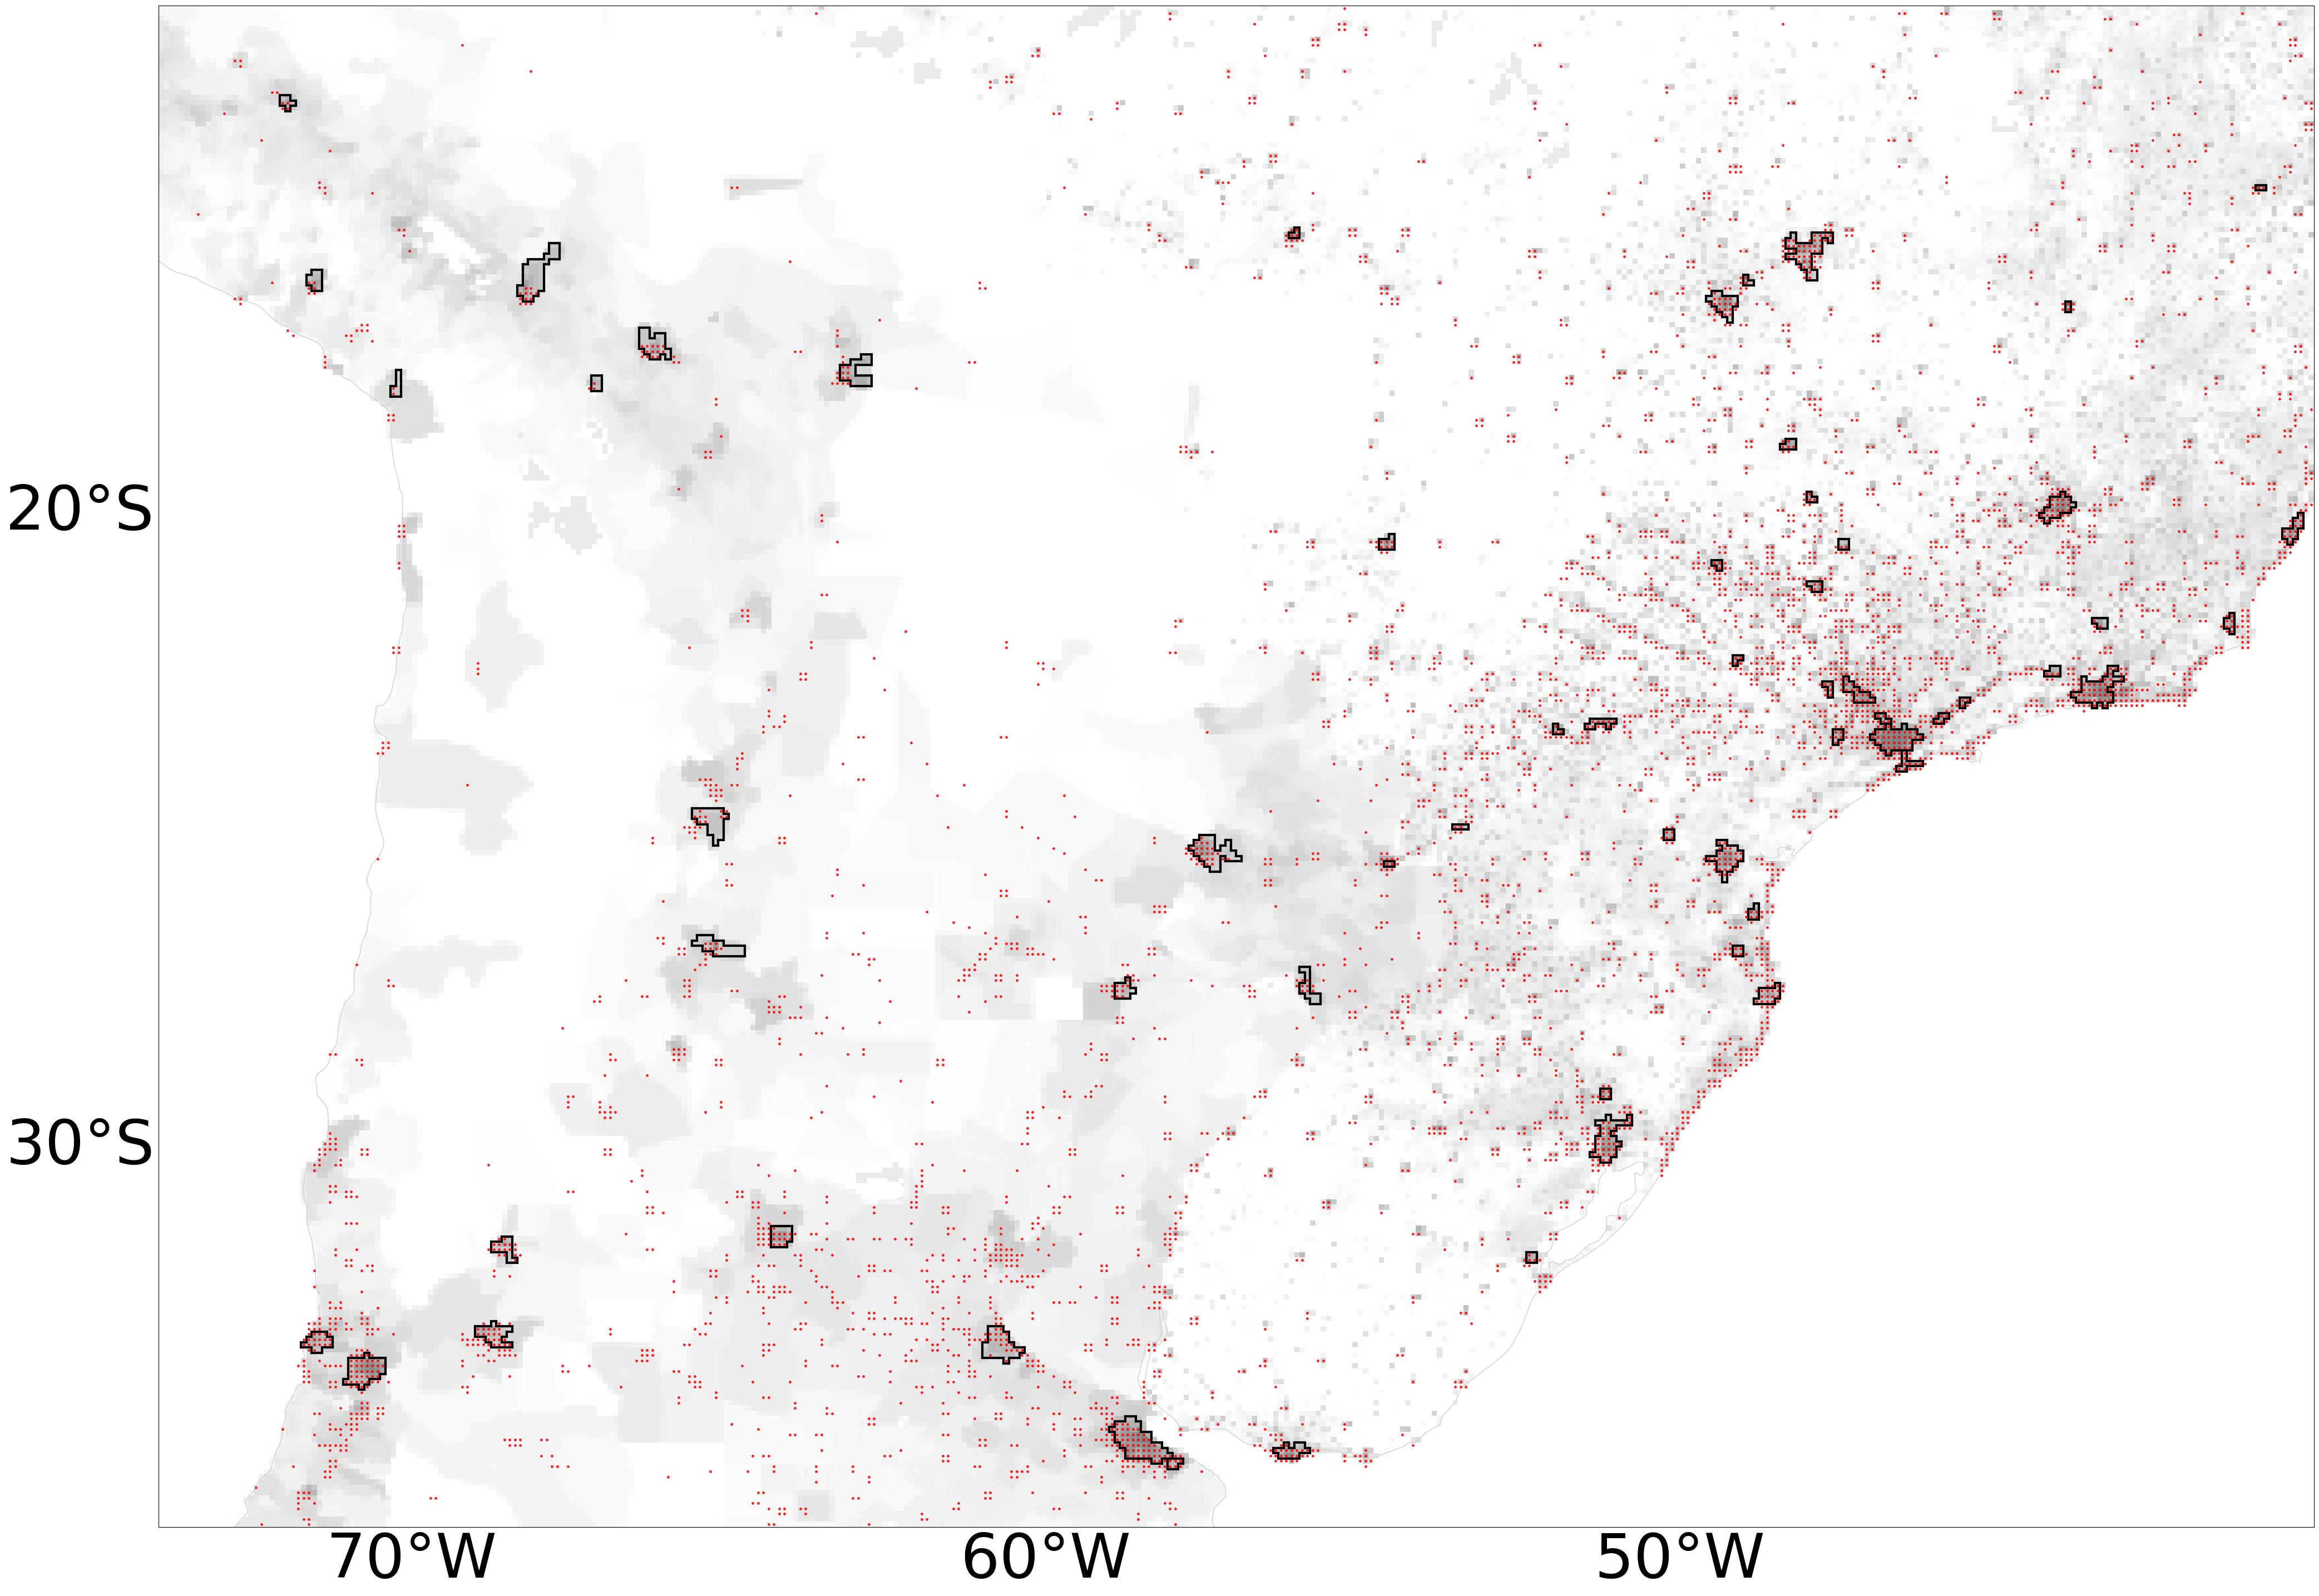

In [104]:
left, right, bottom, top = -74, -40, -36, -12

region_plot(left, right, bottom, top, dotwidth=5, linewidth=3, vmax=1e9)

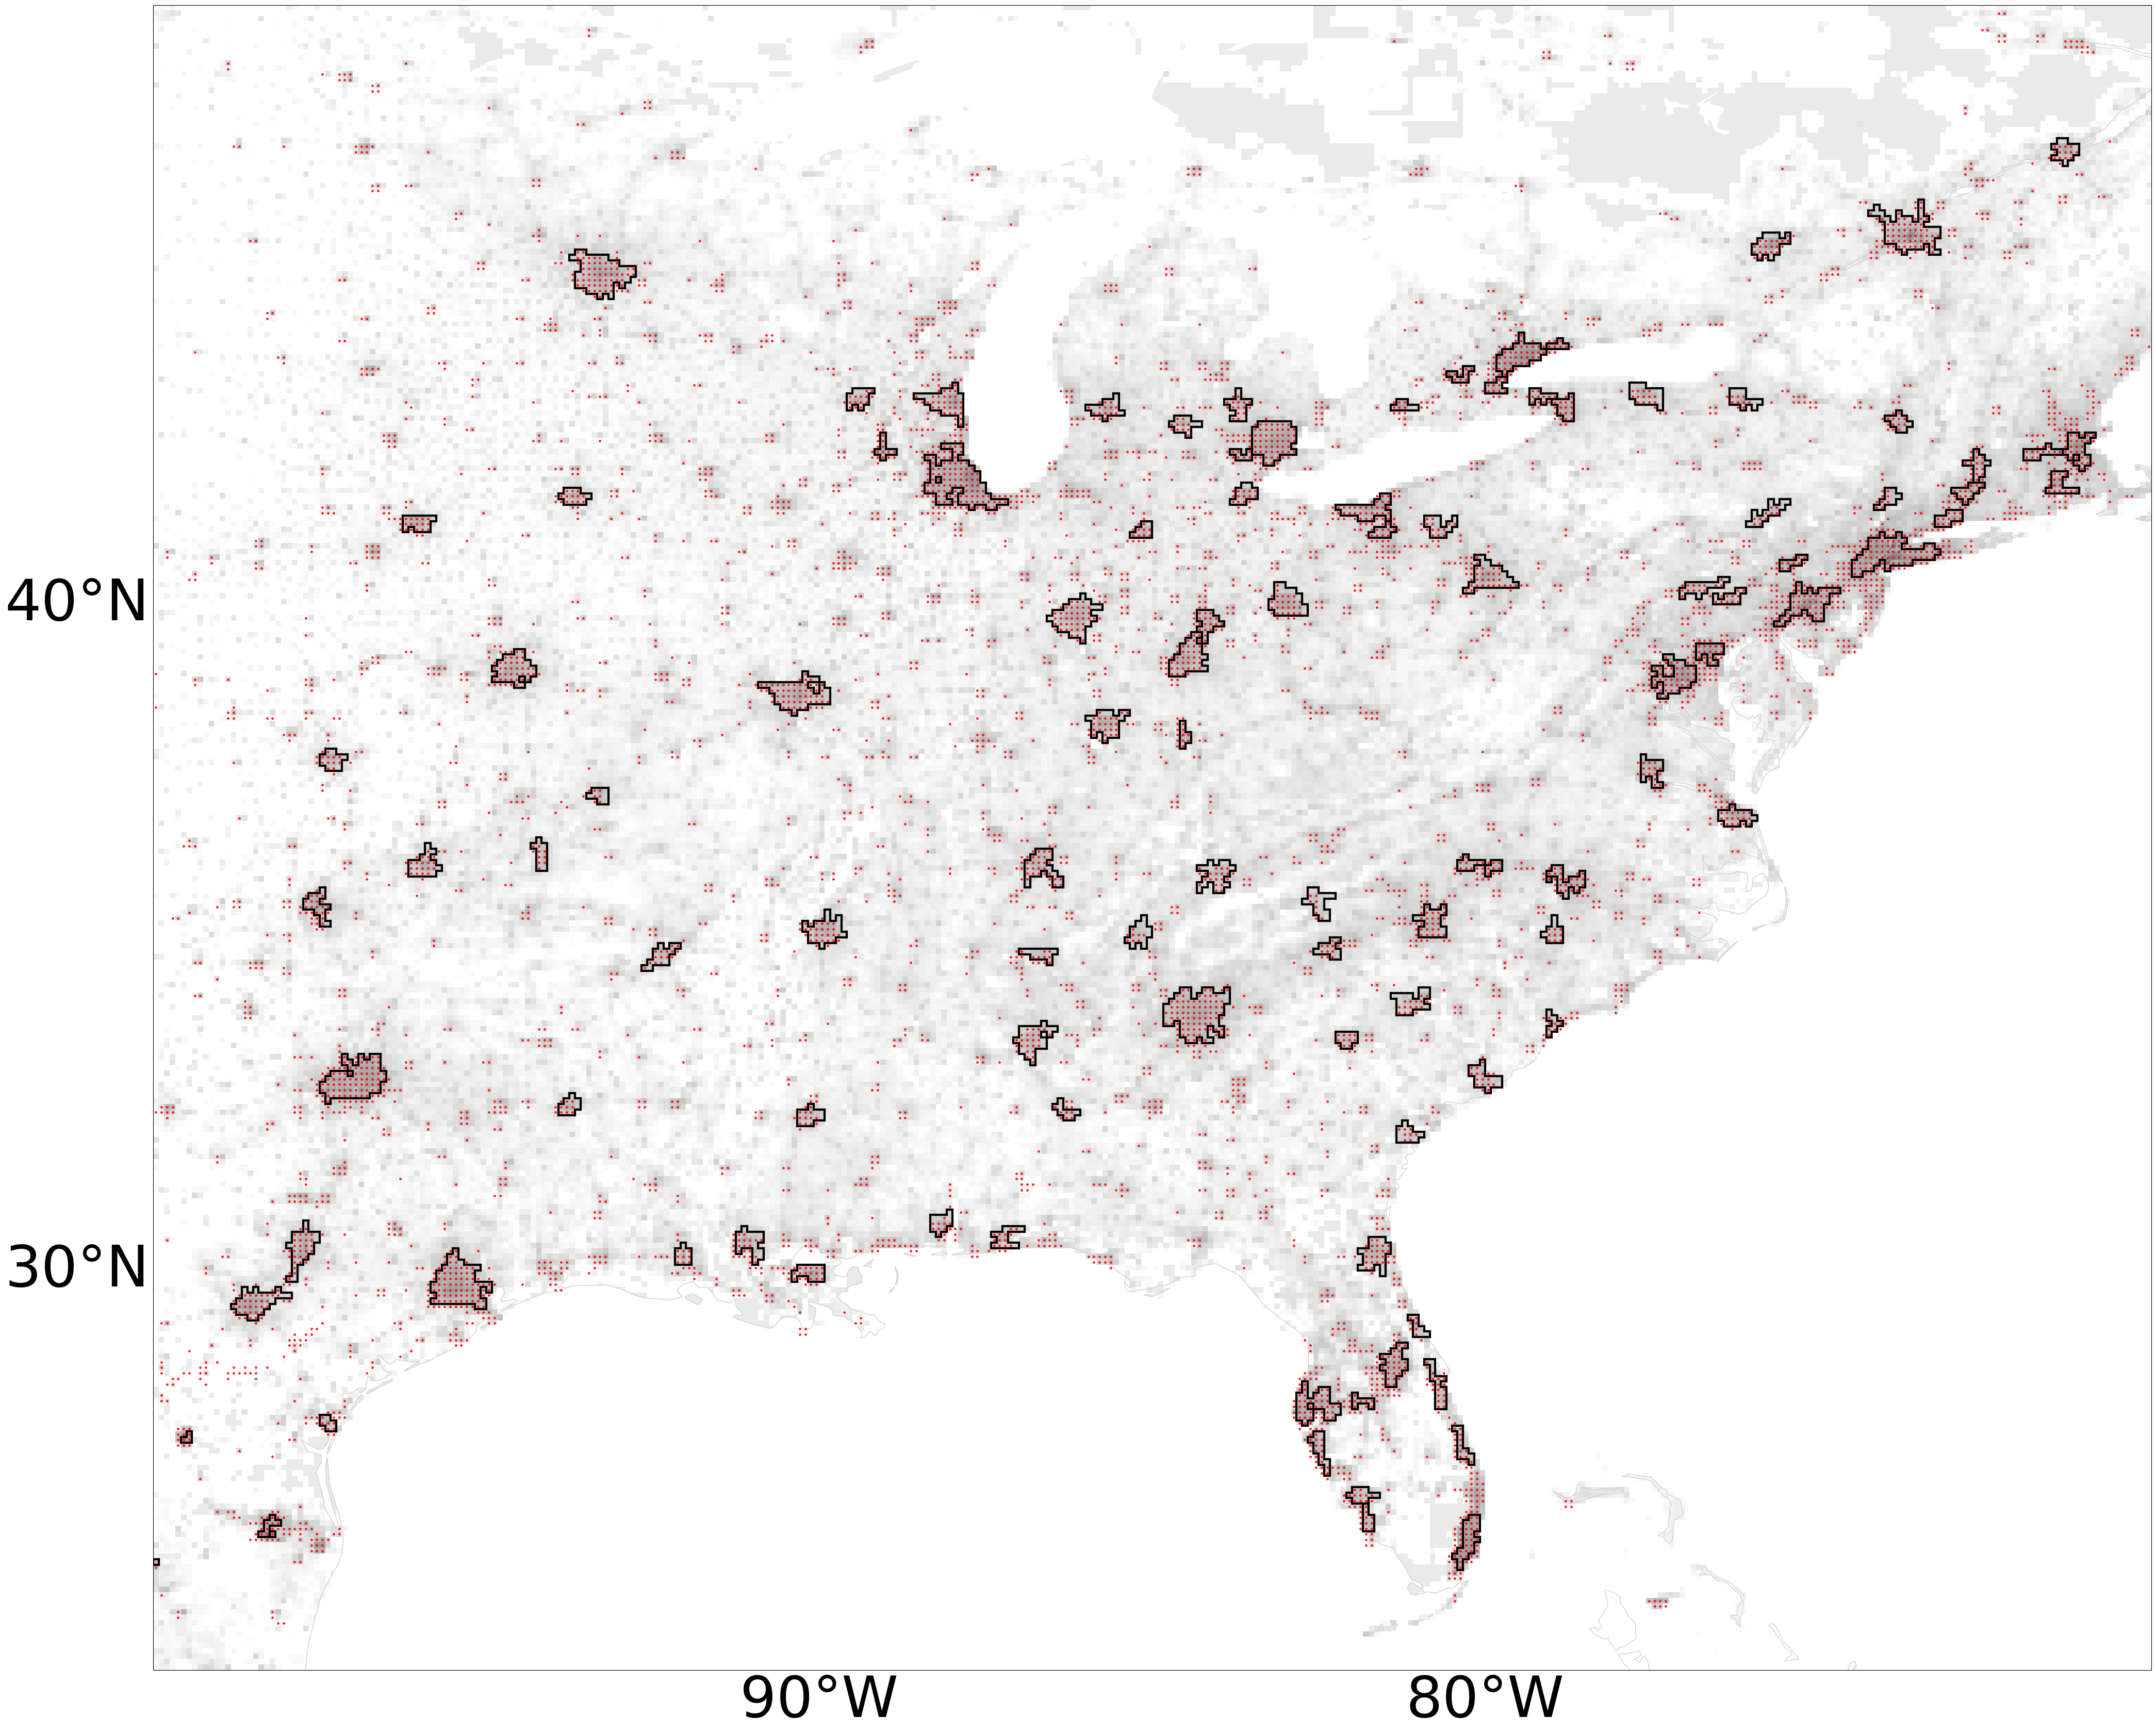

In [100]:
left, right, bottom, top = -100, -70, 24, 49
region_plot(left, right, bottom, top, dotwidth=4, linewidth=3, vmax=1e9)